In [814]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from yahoofinancials import YahooFinancials
from requests_html import HTMLSession
import numpy_financial as npf


In [815]:

ticker_table = 'CHMF' 
ticker = 'CHMF.ME' 


Получаем курс доллара 

In [816]:
session = HTMLSession()
usd_rub_course = session.get('https://finance.rambler.ru/currencies/USD/')
usd_rub = usd_rub_course.html.find('.finance-currency-plate__currency')
USD_COURSE = float(usd_rub[0].text)
USD_COURSE

75.6151

In [817]:
Income_df = pd.read_excel(f'''J:/Новая папка/{ticker_table}/Income Statement_Annual_As Originally Reported.xls''').apply(lambda x: x.str.replace(',', '')).fillna(0)
Balance_df = pd.read_excel(f'''J:/Новая папка/{ticker_table}/Balance Sheet_Annual_As Originally Reported.xls''', index_col=None).apply(lambda x: x.str.replace(',', '')).fillna(0)
Key_Ratios_df = pd.read_csv(f'''J:/Новая папка/{ticker_table}/{ticker_table} Key Ratios.csv''', skiprows=2, index_col='Unnamed: 0').apply(lambda x: x.str.replace(',', ''))
Cash_df = pd.read_excel(f'''J:/Новая папка/{ticker_table}/Cash Flow_Annual_As Originally Reported.xls''').apply(lambda x: x.str.replace(',', '.')).fillna(0)
# Здесь нужно указать путь Excel таблицы на компьютере
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print(Key_Ratios_df)

Key_Ratios_df = Key_Ratios_df.T[::-1]
Key_Ratios_df['date'] = ['TTM','2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
Key_Ratios_df.set_index(['date'], inplace = True)
Balance_df = Balance_df.T[::-1]
Income_df = Income_df.T[::-1]
Cash_df = Cash_df.T[::-1]



try:
    Income_df.columns = Income_df.iloc[11].fillna(0)
    Balance_df.columns = Balance_df.iloc[10].fillna(0)
    Cash_df.columns = Cash_df.iloc[11].fillna(0)
except :
    print('except')
    Balance_df.columns = Balance_df.iloc[9].fillna(0)
    Income_df.columns = Income_df.iloc[9].fillna(0)
    Cash_df.columns = Cash_df.iloc[9].fillna(0)

    
    
try:
    Key_Ratios_df[['revenue', 'eps', 'payout_ratio', 'tax_rate', 'debt_equity', 'bookValuePerShare',
                    'currentRatio', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow'
                   ]] = pd.DataFrame(Key_Ratios_df[['Revenue RUB Mil', 'Earnings Per Share RUB', 'Payout Ratio % *', 'Tax Rate %', 'Debt/Equity',
                                            'Book Value Per Share * RUB', 'Current Ratio', 'Operating Income RUB Mil',
                                            'Net Income RUB Mil', 'Free Cash Flow RUB Mil', 'Shares Mil', 'Dividends RUB',
                                   'Operating Cash Flow RUB Mil']].fillna(0)[0:11].astype(float))
    
    Key_Ratios_df[['revenue', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow']] \
    = Key_Ratios_df[['revenue', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow']] * 1000000

except:    
    Key_Ratios_df[['revenue', 'eps', 'payout_ratio', 'tax_rate', 'debt_equity', 'bookValuePerShare',
                'currentRatio', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow'
               ]] = pd.DataFrame(Key_Ratios_df[['Revenue USD Mil', 'Earnings Per Share USD', 'Payout Ratio % *', 'Tax Rate %', 'Debt/Equity',
                                        'Book Value Per Share * USD', 'Current Ratio', 'Operating Income USD Mil',
                                        'Net Income USD Mil', 'Free Cash Flow USD Mil', 'Shares Mil', 'Dividends USD',
                               'Operating Cash Flow USD Mil']].fillna(0)[0:11].astype(float)) 
    
    Key_Ratios_df[['revenue', 'eps',  'bookValuePerShare', 'operatingIncome', 'netIncome', 'freeCashFlow', 'dividends', 'operatingCashFlow']] \
    = Key_Ratios_df[['revenue', 'eps',  'bookValuePerShare', 'operatingIncome', 'netIncome', 'freeCashFlow', 'dividends', 'operatingCashFlow']] * USD_COURSE
    
    Key_Ratios_df[['revenue', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow']] \
    = Key_Ratios_df[['revenue', 'operatingIncome', 'netIncome', 'freeCashFlow', 'numberOfShares', 'dividends', 'operatingCashFlow']] * 1000000

    
try:   
    Balance_df = Balance_df[['Total Assets', 'Total Liabilities', '    Equity Attributable to Parent Stockholders', '                Current Debt', '                Long Term Debt', 
                            '            Cash and Cash Equivalents', '            Long Term Debt and Capital Lease Obligation'
                ]].fillna(0)[0:10].astype(float)
    Balance_df = Balance_df.T.drop_duplicates().T # удаляем дубликаты столбцов
    Balance_df[['сurrent_debt', 'long_term_debt']] = pd.DataFrame(Balance_df[['                Current Debt', '                Long Term Debt']])
    
except:
    Balance_df = Balance_df[['Total Assets', 'Total Liabilities', '    Equity Attributable to Parent Stockholders', '            Current Debt and Capital Lease Obligation',
                             '                Long Term Debt', '            Cash and Cash Equivalents', 
                             '            Long Term Debt and Capital Lease Obligation']].fillna(0)[0:10].astype(float)
    Balance_df = Balance_df.T.drop_duplicates().T # удаляем дубликаты столбцов
    Balance_df['сurrent_debt'] = pd.DataFrame(Balance_df['                Current Debt'])
    
  

Income_df = Income_df[['    Total Revenue', '            Interest Expense Net of Capitalized Interest', 'Provision for Income Tax', 
                       'Net Income Available to Common Stockholders', 'Gross Profit',
                       'Pretax Income']].fillna(0)[0:10].astype(float)

Income_df = Income_df.T.drop_duplicates().T


                         2010-12  2011-12 2012-12 2013-12 2014-12 2015-12  \
Revenue USD Mil            12819    15812   14104   13312    8296    6396   
Gross Margin %              32.0     98.5    23.5    22.3    34.3    40.8   
Operating Income USD Mil    2095     2889    1321    1192    1568    1668   
Operating Margin %          16.3     18.3     9.4     9.0    18.9    26.1   
Net Income USD Mil          -575     2035     762      83   -1602     605   
...                          ...      ...     ...     ...     ...     ...   
Cash Conversion Cycle      98.76  2218.35   74.51   70.20   82.95   56.90   
Receivables Turnover       10.57    14.46   12.39   10.94    8.14   11.57   
Inventory Turnover          3.26     0.10    4.43    4.73    3.83    5.14   
Fixed Assets Turnover       1.53     2.14    1.75    1.55    1.39    2.10   
Asset Turnover              0.66     0.85    0.84    0.88    0.75    0.95   

                         2016-12 2017-12 2018-12 2019-12    TTM  
Revenue U

In [818]:
Key_Ratios_df

,Revenue USD Mil,Gross Margin %,Operating Income USD Mil,Operating Margin %,Net Income USD Mil,Earnings Per Share USD,Dividends USD,Payout Ratio % *,Shares Mil,Book Value Per Share * USD,...,tax_rate,debt_equity,bookValuePerShare,currentRatio,operatingIncome,netIncome,freeCashFlow,numberOfShares,dividends,operatingCashFlow
date,,,,,,,,,,,,,,,,,,,,,
TTM,7080,39.8,1817,25.7,1003,1.21,1.40,115.6,849,230.48,...,19.23,0.78,17427.768248,1.40,1.373926e+11,7.584195e+10,5.293057e+10,8.490000e+08,105861140.0,1.623456e+11
2019,8157,39.8,2305,28.3,1766,2.08,1.90,93.6,849,244.96,...,20.83,0.72,18522.674896,1.95,1.742928e+11,1.335363e+11,8.121062e+10,8.490000e+08,143668690.0,1.733098e+11
2018,8580,42.7,2702,31.5,2051,2.47,2.42,94.7,848,247.29,...,18.58,0.49,18698.858079,1.85,2.043120e+11,1.550866e+11,1.184132e+11,8.480000e+08,182988542.0,1.704364e+11
2017,7848,39.7,2113,26.9,1356,1.64,1.87,123.6,842,225.75,...,23.19,0.45,17070.108825,1.77,1.597747e+11,1.025341e+11,1.000388e+11,8.420000e+08,141400237.0,1.447273e+11
2016,5916,39.6,1515,25.6,1621,2.00,1.16,63.3,811,220.62,...,5.65,0.44,16682.203362,1.56,1.145569e+11,1.225721e+11,7.198558e+10,8.110000e+08,87713516.0,1.116835e+11
2015,6396,40.8,1668,26.1,605,0.75,0.86,NaN,811,226.67,...,22.15,0.86,17139.674717,2.26,1.261260e+11,4.574714e+10,1.069198e+11,8.110000e+08,65028986.0,1.401148e+11
2014,8296,34.3,1568,18.9,-1602,-1.97,1.34,NaN,811,369.99,...,0.00,0.94,27976.830849,2.09,1.185645e+11,-1.211354e+11,9.519941e+10,8.110000e+08,101324234.0,1.541036e+11
2013,13312,22.3,1192,9.0,83,0.11,0.26,170.3,811,276.54,...,42.74,0.59,20910.599754,1.92,9.013320e+10,6.276053e+09,3.024604e+10,8.110000e+08,19659926.0,1.193206e+11
2012,14104,23.5,1321,9.4,762,0.91,0.38,29.4,839,627.57,...,25.41,0.60,47453.768307,1.69,9.988755e+10,5.761871e+10,2.283576e+10,8.390000e+08,28733738.0,1.323264e+11


## Get Stock Price

In [819]:
# Получаем данные с yahoo finance для одного тикера
price = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1') 

Latest P/E

In [820]:
latest_price = price.loc['2020-11-20','Close']
latest_eps = Key_Ratios_df['eps'][0]# Периоды указываем как в шаге выше
latest_PtoE = latest_price/Key_Ratios_df['eps'][0]
print(latest_PtoE)
print(latest_price)

12.068514663304711
1104.199951171875


Latest P/BV

In [821]:
latest_price = price.loc['2020-11-20','Close']
latest_eps = Key_Ratios_df['bookValuePerShare'][0]
latest_PtoBV = latest_price/latest_eps
print(latest_PtoBV)

0.0633586547318583


In [822]:
type(Balance_df['Total Assets'][0])

numpy.float64

# Расчет WACC

In [823]:
numberOfShares0 = Key_Ratios_df['numberOfShares'][0]
numberOfShares1 = Key_Ratios_df['numberOfShares'][0] # Периоды указываем как в шаге выше
numberOfShares = numberOfShares0
numberOfShares

849000000.0

In [824]:
start = datetime.datetime(2019, 2, 1)
end = datetime.datetime.today().strftime('%Y-%m-%d')
beta = YahooFinancials(ticker).get_beta()
mktCap_2019 =  numberOfShares * (latest_price)


# Treasury = wb.DataReader(['DGS10'], 'fred', start, end) # найти способ взять для русских компаний 
# RF = float(Treasury.iloc[-1])

# ________________________________________ Парсим RF ___________________________
session = HTMLSession()
r = session.get('https://quote.rbc.ru/ticker/119252')
RF_pars = r.html.xpath('''/html/body[@class='ticker-view g-body-bottom-padding']/div[@class='l-window l-window-overflow-mob']/div[@class='g-relative g-clear']/div[@class='l-col-container']/div[@class='l-table']/div[@class='g-relative']/div[@class='l-table l-table-min-height']/div[@class='l-col-main']/div[@class='q-item__bonds']/div[@class='q-item__bonds__wrap l-col-center-590']/div[@class='q-item__bonds__list']/div[@class='q-item__bonds__item'][1]/div[@class='q-item__bonds__info']/div[@class='q-item__bonds__value']''')

RF = float(RF_pars[0].text[:-1].replace(',', '.'))
print(RF)
# RF = 0.0509
    
data = wb.DataReader('IMOEX.ME', data_source='yahoo', start='2007-1-1')  # заменить индекс на мосбиржи
data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
data['simple_return'].replace(np.nan, 0)
avg_returns_a = data['simple_return'].mean() * 250
    
ke = RF + (float(beta) * (avg_returns_a - RF))
# ke = RF + (float(work_table['beta'][0]) * (avg_returns_a - RF))



6.01


In [825]:
# Income_df['Provision'] = Income_df['Provision for Income Tax']

# Income_df['Provision for Income Tax'].T.groupby(level=0).first().T



In [826]:
Balance_df['netDebt'] =  Balance_df['сurrent_debt'] + Balance_df['                Long Term Debt'] \
              -  Balance_df['            Cash and Cash Equivalents']


WACC = (mktCap_2019 / (mktCap_2019 + Balance_df['netDebt'][0:2].mean())) * ke + (
        Balance_df['netDebt'][0:2].mean() / (mktCap_2019 + Balance_df['netDebt'][0:2].mean())) * (
               Income_df['            Interest Expense Net of Capitalized Interest'][1] / Balance_df['netDebt'][0:2].mean())* \
        (1 + (Income_df['Provision for Income Tax'][1] / Income_df['Pretax Income'][1]))



WACC

0.9666923168686317

In [827]:
print(f'mktCap_2019 {mktCap_2019}')
print(f'''balance_table netDebt {Balance_df['netDebt'][0:2].mean()}''')
print(f'''ke {ke}''')
print(f'''interestExpense_2019 {Income_df['            Interest Expense Net of Capitalized Interest'][1]}''')
print(f'''incomeTaxExpense_2019 {Income_df['Provision for Income Tax'][1]}''')
print(f'''incomeBeforeTax_2019 {Income_df['Pretax Income'][1]}''')
print(f'''WACC {WACC}''')
print(f'''numberOfShares {numberOfShares}''')
print(f'''latest_price {latest_price}''')
print("*"* 50)
print(f'''RF {RF}''')

 

mktCap_2019 937465758544.9219
balance_table netDebt 1198500000.0
ke 0.9680438745799949
interestExpense_2019 -137000000.0
incomeTaxExpense_2019 -465000000.0
incomeBeforeTax_2019 2232000000.0
WACC 0.9666923168686317
numberOfShares 849000000.0
latest_price 1104.199951171875
**************************************************
RF 6.01


## Calculating intrinsic value

Расчет методом дивидендов и балансовой стоимости

In [828]:
dvd_avg = Key_Ratios_df['dividends'].mean() # Определим средний дивиденд
print(dvd_avg)

83864020.0


In [829]:
# risk_free_rate = 0.18 # подставить WACC 
# The discounted capital for the dividend of 3-year later
dvd_avg/(1+WACC)**3
# The discounted capital for the dividend of 10-year later
#dvd_avg/(1+risk_free_rate)**10

11024690.66926012

In [830]:
dvd_total = 0
for i in range(1,11):
    dvd_total = dvd_total + dvd_avg/(1+WACC)**i
print(dvd_total)

86653367.97884077


Estimate future book value

In [831]:
growth_rate_of_9y= Key_Ratios_df['bookValuePerShare'][0]/Key_Ratios_df['bookValuePerShare'][8] # Периоды указываем как в шаге выше
avg_growth_rate = growth_rate_of_9y**(1/9)
print(avg_growth_rate)

0.8946711895397021


In [832]:
bvps_pred = Key_Ratios_df['bookValuePerShare'][0]*(avg_growth_rate**10) # Периоды указываем как в шаге выше
print(bvps_pred)

5726.329035816934


## Стоимость акции по дивам и балансовой стоимости (наивный метод)

In [833]:
data_intrinsic = bvps_pred + dvd_total
print(data_intrinsic)

86659094.30787659


In [834]:
data_intrinsic - latest_price #Маржа безопасности

86657990.10792542

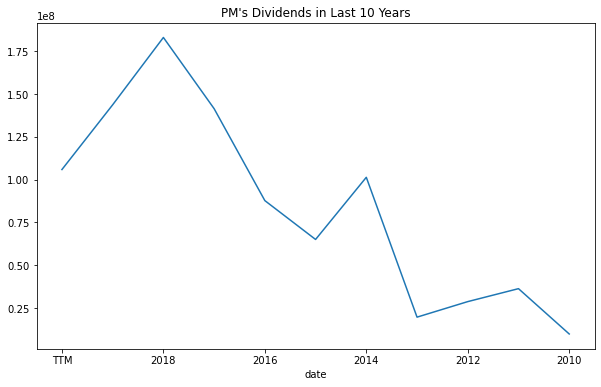

In [835]:
Key_Ratios_df['dividends'].plot(figsize=(10,6), title="PM's Dividends in Last 10 Years")

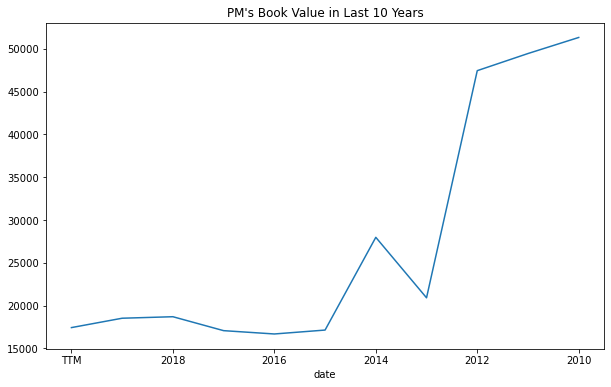

In [836]:
Key_Ratios_df['bookValuePerShare'].plot(figsize=(10,6), title="PM's Book Value in Last 10 Years")

### Расчет стоимости по дивам и балансовой стоимости с помощью линейной регрессии

In [837]:
# 'year_index' as the order of the year
data['year_index'] = range(1, len(data) + 1)
# add intercept
data['intercept'] = 1

In [838]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,simple_return,year_index,intercept
Date,,,,,,,,,
2013-03-04,1477.270020,1461.489990,1473.540039,1464.449951,0.0,1464.449951,NaN,1,1
2013-03-05,1486.729980,1485.040039,1485.040039,1486.420044,0.0,1486.420044,0.015002,2,1
2013-03-06,1498.020020,1485.040039,1485.040039,1491.489990,0.0,1491.489990,0.003411,3,1
2013-03-07,1498.290039,1489.020020,1491.989990,1491.349976,0.0,1491.349976,-0.000094,4,1
2013-03-11,1506.420044,1503.640015,1503.979980,1505.930054,0.0,1505.930054,0.009776,5,1


In [839]:

# 'year_index' as the order of the year
Key_Ratios_df['year_index'] = range(1, len(Key_Ratios_df) + 1)[::-1]
# add intercept
Key_Ratios_df['intercept'] = 1
# print(Key_Ratios_df['year_index'])

bvps_model = sm.OLS(Key_Ratios_df['bookValuePerShare'], Key_Ratios_df[['year_index', 'intercept']]).fit()

bvps_pred_lr = bvps_model.predict([19, 1])[0] #Прогнозируем балансовую стоимость через 10 лет
print(bvps_pred_lr)

-19579.773993999974


In [840]:
dvd_model = sm.OLS(Key_Ratios_df['dividends'], Key_Ratios_df[['year_index','intercept']]).fit()


In [841]:
dvd_model.predict([19,1])[0] #Определить дивиденд через 10 лет

273224852.7

In [842]:
# Дивиденды за 10 лет
dvd_total_lr = 0
current_year_order = 9
for i in range(1,11):
    dvd_new = dvd_model.predict([current_year_order + i,1])[0]
    dvd_total_lr = dvd_total_lr + dvd_new/(1+WACC)**i
print(dvd_total_lr)

162251364.39850667


In [843]:
aapl_intrinsic_lr = dvd_total_lr + bvps_pred_lr
print(aapl_intrinsic_lr)

162231784.62451267


In [844]:
aapl_intrinsic_lr - latest_price #Маржа безопасности

162230680.4245615

Пиотроски F-score

In [845]:
# Считаем F-Score. Формула не идеальная, к ней есть вопросы

cashflow_op = (Key_Ratios_df['operatingCashFlow'][0] + Key_Ratios_df['operatingCashFlow'][1] + Key_Ratios_df['operatingCashFlow'][2] \
               + Key_Ratios_df['operatingCashFlow'][3]) 

ROA_FS = (round(Income_df['Net Income Available to Common Stockholders'][0]/((Balance_df['Total Assets'][0] + Balance_df['Total Assets'][1])/2), 2)>0)  
CFO_FS = int(Key_Ratios_df['operatingCashFlow'][0]>0)
ROA_D_FS = int((round(Income_df['Net Income Available to Common Stockholders'][0]/((Balance_df['Total Assets'][0] + Balance_df['Total Assets'][1])/2), 2))>
               (round(Income_df['Net Income Available to Common Stockholders'][1]/((Balance_df['Total Assets'][1] + Balance_df['Total Assets'][2])/2), 2)))
CFO_ROA_FS = int((cashflow_op/Balance_df['Total Assets'][0])>(Income_df['Net Income Available to Common Stockholders'][0]/ ((Balance_df['Total Assets'][0] + Balance_df['Total Assets'][1])/2)))          
CR_FS = int((Balance_df['Total Assets'][0]/Balance_df['Total Liabilities'][0])>      
             (Balance_df['Total Assets'][1]/Balance_df['Total Liabilities'][1]))           
LTD_FS = int(Balance_df['            Long Term Debt and Capital Lease Obligation'][0] <= Balance_df['            Long Term Debt and Capital Lease Obligation'][1])
DILUTION_FS = int(numberOfShares0  <= numberOfShares1)
GM_FS = int(Income_df['Gross Profit'][0]/Income_df['    Total Revenue'][0] > Income_df['Gross Profit'][1]/Income_df['    Total Revenue'][1])
ATO_FS = int((Income_df['    Total Revenue'][0]/((Balance_df['Total Assets'][0] + Balance_df['Total Assets'][1])/2)) >
            (Income_df['    Total Revenue'][1]/((Balance_df['Total Assets'][1] + Balance_df['Total Assets'][2])/2)))
F_score = ROA_FS + CFO_FS + ROA_D_FS + CFO_ROA_FS + LTD_FS + CR_FS + DILUTION_FS + GM_FS + ATO_FS  

print(f'f_score is {F_score}')


# Вопросы к методике 
#1. ПРи расчете ROA_FS, мы исследуем число на предмет положительности относительно нуля, но это может быть только в одном случае, если числитель больше нуля, тогда в этой формуле знаменатель не нужен, ведь он в принципе не может быть меньше ноля
#2. Зачем нам складывать в знаменателях значения за 2 года?
#3. При сравнениее OCF не обязательно приводить показатель к миллиардам, т.к. нас интересует в принципе он больше нуля или нет
#4. Почему мы считаем cashflow_op как сумма за 4 последних года, если в принципе нас интересует конкретно за последний год


f_score is 4


In [846]:
# 'year_index' as the order of the year
Key_Ratios_df['year_index'] = range(1, len(Key_Ratios_df) + 1)[::-1]
# add intercept
Key_Ratios_df['intercept'] = 1

Key_Ratios_df['freeCashFlow'] = Key_Ratios_df['freeCashFlow']
# print(work_table)

# modeling
freeCashFlow_model = sm.OLS(Key_Ratios_df['freeCashFlow'], Key_Ratios_df[['year_index', 'intercept']]).fit()

freeCashFlow_pred_lr = freeCashFlow_model.predict([19, 1])[0]  # Прогнозируем через 10 лет

freeCashFlow_pred_lr5 = freeCashFlow_model.predict([14, 1])[0]  # Прогнозируем через 5 лет
freeCashFlow_pred_lr4 = freeCashFlow_model.predict([13, 1])[0]
freeCashFlow_pred_lr3 = freeCashFlow_model.predict([12, 1])[0]
freeCashFlow_pred_lr2 = freeCashFlow_model.predict([11, 1])[0]
freeCashFlow_pred_lr1 = freeCashFlow_model.predict([10, 1])[0]

# CAGR FCF

CF_forecast = {}

CF_forecast['next_year1'] = {}
CF_forecast['next_year1']['freeCashFlow'] = freeCashFlow_pred_lr1

CF_forecast['next_year2'] = {}
CF_forecast['next_year2']['freeCashFlow'] = freeCashFlow_pred_lr2

CF_forecast['next_year3'] = {}
CF_forecast['next_year3']['freeCashFlow'] = freeCashFlow_pred_lr3

CF_forecast['next_year4'] = {}
CF_forecast['next_year4']['freeCashFlow'] = freeCashFlow_pred_lr4

CF_forecast['next_year5'] = {}
CF_forecast['next_year5']['freeCashFlow'] = freeCashFlow_pred_lr5

# print(CF_forecast)

print(f'freeCashFlow_pred_lr1 = {freeCashFlow_pred_lr1}')
print(f'freeCashFlow_pred_lr2 = {freeCashFlow_pred_lr2}')
print(f'freeCashFlow_pred_lr3 = {freeCashFlow_pred_lr3}')
print(f'freeCashFlow_pred_lr4 = {freeCashFlow_pred_lr4}')
print(f'freeCashFlow_pred_lr5 = {freeCashFlow_pred_lr5}')

# print(freeCashFlow_pred_lr)

print(Key_Ratios_df['freeCashFlow'])
print(Key_Ratios_df['freeCashFlow'][0])

freeCashFlow_pred_lr1 = 102035015940.00002
freeCashFlow_pred_lr2 = 112931151850.00002
freeCashFlow_pred_lr3 = 123827287760.00002
freeCashFlow_pred_lr4 = 134723423670.00002
freeCashFlow_pred_lr5 = 145619559580.0
date
TTM     5.293057e+10
2019    8.121062e+10
2018    1.184132e+11
2017    1.000388e+11
2016    7.198558e+10
2015    1.069198e+11
2014    9.519941e+10
2013    3.024604e+10
2012    2.283576e+10
2011    2.185276e+10
2010   -5.867732e+10
Name: freeCashFlow, dtype: float64
52930570000.0


In [847]:
LTGrowth = 0.02
LTdis = 0.08
PRICE = wb.get_quote_yahoo(f'{ticker_table}.ME')['price']


CF_forec = pd.DataFrame.from_dict(CF_forecast, orient='columns')

FCF_List = CF_forec.iloc[0:].values.tolist()

npv = npf.npv(WACC, FCF_List[0])
print(f'npv = {npv}')

Terminal_value_Discounted = freeCashFlow_pred_lr * (1 + LTGrowth) / (LTdis - LTGrowth)

print(f'Terminal_value_Discounted = {Terminal_value_Discounted}')

sum_num = npv + Terminal_value_Discounted
print(f'sum_num = {sum_num}')

spl_num = sum_num / (Key_Ratios_df['numberOfShares'][0])
print(f'Estimated price = {spl_num}')

difference_model_and_market_value = spl_num - PRICE

print(f'stock price = {PRICE}')

print(f'difference_model_and_market_value = {difference_model_and_market_value}')

npv = 218915385642.90668
Terminal_value_Discounted = 3401704065210.0
sum_num = 3620619450852.9067
Estimated price = 4264.569435633577
stock price = CHMF.ME    1141.6
Name: price, dtype: float64
difference_model_and_market_value = CHMF.ME    3122.969436
Name: price, dtype: float64
